In [ ]:
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib as mpl

import seaborn as sns
sns.set_palette("muted")
import matplotlib.pyplot as plt
import math
import os
%matplotlib inline


In [2]:
def truncate_normal(input: torch.Tensor, radius):
    in_norm = input.norm(dim=1, keepdim=True)
    in_norm[in_norm > radius] = radius
    return input * in_norm / input.norm(dim=1, keepdim=True)

In [3]:
from itertools import product

run = 0

configs = ["none", "us"]
# configs = ['us']

mu_one = torch.tensor([[0, 5]])
mu_two = torch.tensor([[5, 0]])

sigma = 1.

seed = 2

all_class_one_num = 50
all_class_two_num = 500


assert all_class_one_num < all_class_two_num

num_epochs = int(1e4)
lr = 0.5


for config in configs:

    torch.random.manual_seed(seed)

    val_num = 1000
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    class_one_num = all_class_one_num
    class_two_num = all_class_two_num

    class_one = truncate_normal(sigma * torch.randn(class_one_num, 2), 5) + mu_one
    class_two = truncate_normal(sigma * torch.randn(class_two_num, 2), 5) + mu_two

    val_one = truncate_normal(sigma * torch.randn(val_num, 2), 5) + mu_one
    val_two = truncate_normal(sigma * torch.randn(val_num, 2), 5) + mu_two

    if config == "us":
        class_two_num = class_one_num
        class_two = class_two[:class_two_num]

    batch_size = class_one_num + class_two_num

    x_seq = torch.cat((class_one, class_two), dim=0)
    y_seq = torch.cat(
        (torch.zeros(class_one.shape[0], dtype=torch.long), torch.ones(class_two.shape[0], dtype=torch.long))
    )

    val_x = torch.cat((val_one, val_two), dim=0)
    val_y = torch.tensor([0] * val_num + [1] * val_num, dtype=torch.long)

    dataset = torch.utils.data.TensorDataset(x_seq, y_seq)
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=True
    )

    model = torch.nn.Linear(2, 2, bias=True)
    
    model.weight.data = torch.zeros_like(model.weight)
    model.bias.data = torch.zeros_like(model.bias)
    
    model = model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

    optimizer = optim.SGD(model.parameters(), lr=lr)

    prev_val_loss = None

    for i in range(num_epochs):
        for xs, ys in dataloader:
            xs = xs.to(device)
            ys = ys.to(device)

            optimizer.zero_grad()

            logits = model(xs)

            if config == "IW":
                loss_ratio = (ys == 1) + (ys == 0) * class_two_num / float(class_one_num)
            else:
                loss_ratio = torch.ones(ys.shape[0])

            loss_ratio = loss_ratio.to(device)
            
            loss = torch.mean(loss_fn(logits, ys) * loss_ratio)

            loss.backward()

            optimizer.step()
        
        if i % 1000 == 0:

            val_x = val_x.to(device)
            val_y = val_y.to(device)

            val_logits = model(val_x)
            val_loss = torch.mean(loss_fn(val_logits, val_y))

            val_loss = torch.sum(1. * (val_logits.argmax(axis=1) != val_y))

            print(f"Epoch {i}: loss={loss.item()}, val_loss={val_loss.item()}")

            if prev_val_loss is not None and val_loss > prev_val_loss and i > 10:
                break
            
            prev_val_loss = val_loss

    model = model.cpu()
    current_directory = os.getcwd()
    final_directory = os.path.join(current_directory, 'weights')
    if not os.path.exists(final_directory):
        os.makedirs(final_directory)
        

    torch.save(model.state_dict(), f"./weights/model_{config}_{lr}_{num_epochs}.ckpt")   

Epoch 0: loss=0.6931474208831787, val_loss=383.0
Epoch 1000: loss=0.00041563637205399573, val_loss=1.0
Epoch 2000: loss=0.0002576771657913923, val_loss=1.0
Epoch 3000: loss=0.0001911999424919486, val_loss=1.0
Epoch 4000: loss=0.00015364222053904086, val_loss=1.0
Epoch 5000: loss=0.0001292061060667038, val_loss=1.0
Epoch 6000: loss=0.00011191199155291542, val_loss=1.0
Epoch 7000: loss=9.89674445008859e-05, val_loss=1.0
Epoch 8000: loss=8.887767762644216e-05, val_loss=0.0
Epoch 9000: loss=8.077385427895933e-05, val_loss=0.0
Epoch 0: loss=0.6931471228599548, val_loss=0.0
Epoch 1000: loss=0.0003442117595113814, val_loss=0.0
Epoch 2000: loss=0.00019211143080610782, val_loss=0.0
Epoch 3000: loss=0.00013516865146812052, val_loss=0.0
Epoch 4000: loss=0.00010490711429156363, val_loss=0.0
Epoch 5000: loss=8.60041836858727e-05, val_loss=0.0
Epoch 6000: loss=7.302218728000298e-05, val_loss=0.0
Epoch 7000: loss=6.353083153953776e-05, val_loss=0.0
Epoch 8000: loss=5.62769673706498e-05, val_loss=0.0


/Users/niladri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: The input object of type 'Bbox' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Bbox', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


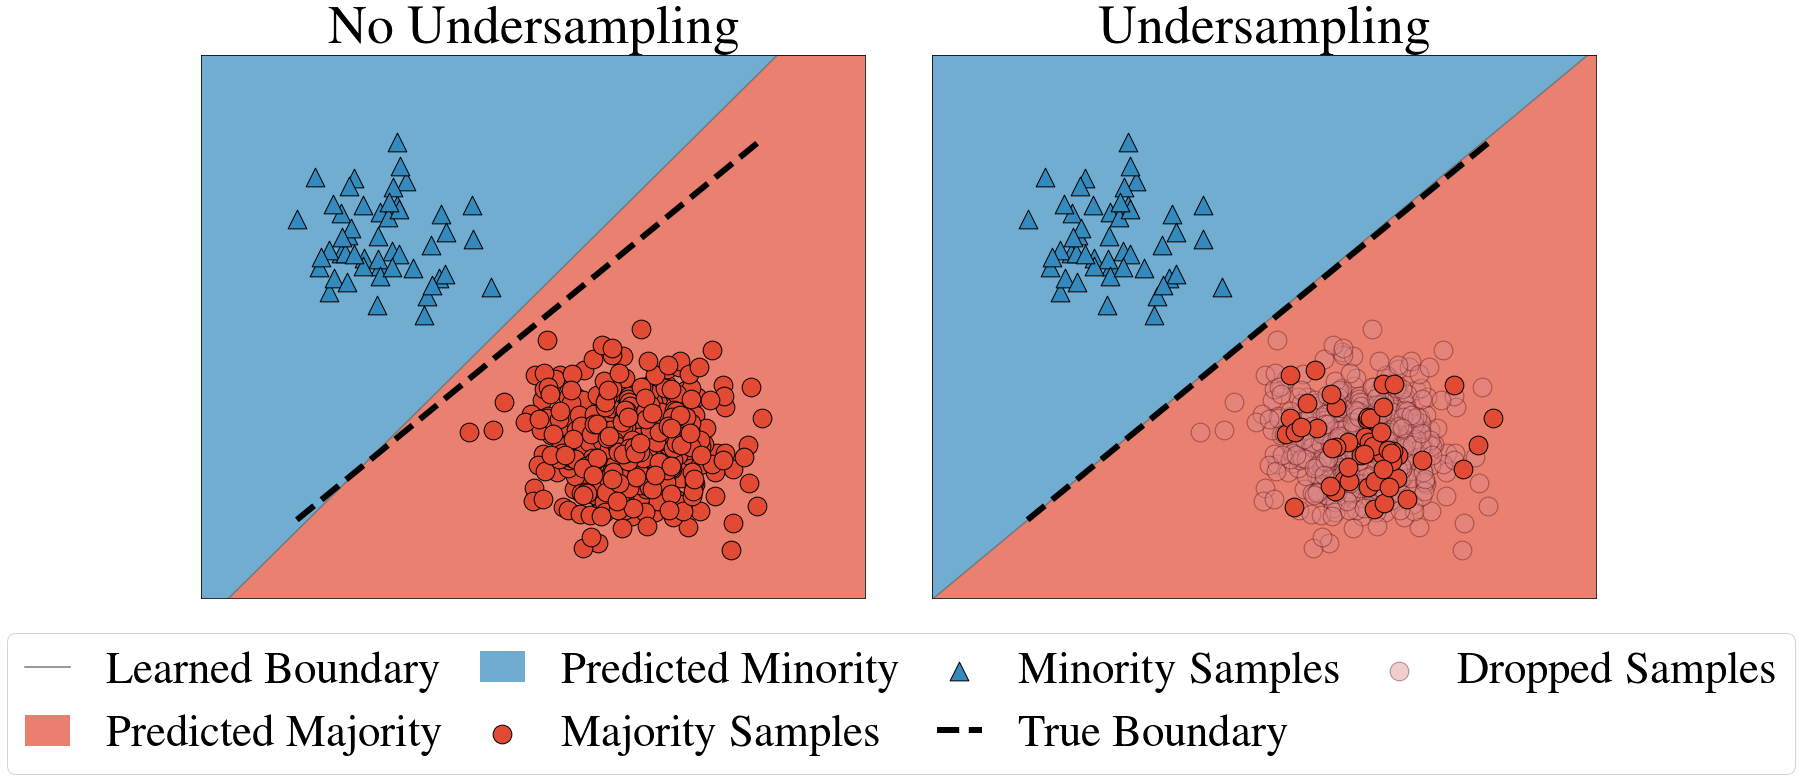

In [74]:
from itertools import product
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rcParams['font.size'] = '45'
palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8', '#DD8888']
sns.set_palette(palette)

#plt.subplots_adjust(left=None, bottom=None, right=10000, top=1000, wspace=10000, hspace=100)
fig, axes = plt.subplots(figsize=(25, 10), ncols=2)


def ymap(xseq, weight, bias):
    print(weight)
    print(bias)
    return (xseq * weight[0] + bias) / (-1 * weight[1])

for i,config in enumerate(configs):
    
    torch.random.manual_seed(seed)

    class_one_num = all_class_one_num
    class_two_num = all_class_two_num

    batch_size = class_one_num + class_two_num
    device = "cuda"

    class_one = truncate_normal(sigma * torch.randn(class_one_num, 2), 5) + mu_one
    class_two = truncate_normal(sigma * torch.randn(class_two_num, 2), 5) + mu_two


    # class_one = truncate_normal(torch.randn(10000, 2), 5) + mu_one
    # class_two = truncate_normal(torch.randn(10000, 2), 5) + mu_two

    x_seq = torch.cat((class_one, class_two), dim=0)
    y_seq = torch.cat(
        (torch.zeros(class_one.shape[0], dtype=torch.long), torch.ones(class_two.shape[0], dtype=torch.long))
    )
    
    
    model = torch.nn.Linear(2, 2, bias=True)
    model.load_state_dict(torch.load(f"./weights/model_{config}_{lr}_{num_epochs}.ckpt"))
    model = model.cpu()

    ax = axes.flatten()[i]

    xlim = ylim = (-4, 10)
    ax.set(ylim=ylim, xlim=xlim)

    def decision_boundary(model, x0):
        if model.bias is not None:
            w, b = model.weight.detach().numpy(), model.bias.detach().numpy()
        else:
            w, b = model.weight.detach().numpy(), [0,0]
        
        x1 = ((w[1, 0] - w[0, 0]) * x0 + (b[1] - b[0])) / (w[0, 1] - w[1, 1])
        return x1
    x0 = np.linspace(*xlim)
    x1 = decision_boundary(model, x0)
    ax.plot(x0, x1, color=palette[3], label="Learned Boundary")
    ax.fill_between(x0, x1 - 100, x1, alpha=0.7, label="Predicted Majority")
    ax.fill_between(x0, x1, x1 + 100, alpha=0.7, label="Predicted Minority")
    
    if config == "us":
        ax.scatter(class_two[class_one_num:, 0], class_two[class_one_num:, 1], c=palette[7], edgecolors="#440000", marker="o", lw=1, s=350, alpha=0.4, label="Dropped Samples")
        ax.scatter(class_two[:class_one_num, 0], class_two[:class_one_num, 1], c=palette[0], edgecolors="k", marker="o", lw=1, s=350, label="Majority Samples")
    else:
        ax.scatter(class_two[:, 0], class_two[:, 1], c=palette[0], edgecolors="k", marker="o", lw=1, s=350, label="Majority Samples")

    ax.scatter(class_one[:, 0], class_one[:, 1], c=palette[1], edgecolors="k", marker="^", lw=1, s=350, label="Minority Samples")

    xrng = np.linspace(min(x_seq[:, 0]), max(x_seq[:, 0]), num=50)
    ax.plot(xrng, xrng, color="black", linewidth=6, linestyle="--", label="True Boundary")
    ax.set(xticklabels=[], yticklabels=[])
    ax.set_xticks([])
    ax.set_yticks([])
    

    if config == "us":
        ax.set(title="Undersampling")
    else:
        ax.set(title="No Undersampling")

    ax.grid(False)
    
import matplotlib.transforms as mtrans

fig.subplots_adjust(wspace=0.1, hspace=0.1)

r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())


print(axes.flat)

bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(2)

# #Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(len(bboxes)).max(axis=0)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(len(bboxes)).min(axis=0)
ys = np.c_[ymax, ymin].mean(axis=1)

# Draw a horizontal lines at those coordinates
# for y in ys:
#     line = plt.Line2D([y-0.021,y-0.021],[0.127, 0.94], transform=fig.transFigure, color="black", linewidth=2)
#     fig.add_artist(line)

ax = axes.flatten()[1]
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, ncol=3, loc="lower center", handlelength=2, columnspacing=5, bbox_to_anchor=(0.5, -0.13))

i = labels.index("Dropped Samples")
labels.append(labels.pop(i))
handles.append(handles.pop(i))

fig.legend(handles, labels, ncol=4, loc="lower center", handlelength=1.0, columnspacing=0.8, bbox_to_anchor=(0.514, -0.15))
# fig.legend(loc="lower center", ncol=3)

In [75]:
fig.savefig("linear_intuition.pdf", bbox_inches="tight",format='pdf')